<a href="https://colab.research.google.com/github/OmerTurk1/ML-From-Scratch/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import numpy as np

In [2]:
def create_dataset(n=300):
    vals1 = np.random.randint(1, 151, size=n)
    vals2 = np.random.randint(1, 151, size=n)
    df = pd.DataFrame({
        "val1": vals1,
        "val2": vals2,
        "cls": ((vals1 <= 50) | ((vals1 <= 100) & (vals2 <= 50)) | (vals2 >= 100)).astype(int)
    })
    return df

In [3]:
df = create_dataset()
df.head()

,val1,val2,cls
0,22,149,1
1,134,15,0
2,5,4,1
3,97,55,0
4,106,94,0


In [4]:
class Node:
    def __init__(self, tree, value=None, depth=0, cond=None):
        self.right = None
        self.left = None
        self.value = value
        self.g = 0
        self.cond = cond
        self.depth = depth
        self.tree = tree

    def predict(self, samp):
        if self.right==None and self.left==None:
            return self.value # o node'un değeri (en çok bulunan öge)
        elif self.cond(samp):
            return self.left.predict(samp)
        else:
            return self.right.predict(samp)

    def best_split(self,mini_df,target,var):
        mini_df = mini_df.sort_values(by=var)
        result = [-1,2] # sınır, gini, sınırın altı, sınırın üstü
        st = sorted(list(set(mini_df[var])))
        for i in range(len(st)-1):
            s = (st[i]+st[i+1])/2
            lower_targ = mini_df[mini_df[var]<s][target]
            upper_targ = mini_df[mini_df[var]>=s][target]
            weighted = (len(lower_targ)*self.tree.gini(lower_targ) + len(upper_targ)*self.tree.gini(upper_targ))/(mini_df.shape[0])
            if result[1]>weighted:
                result=[s,weighted, lower_targ.mode()[0], upper_targ.mode()[0]]
        return result

    def best_choice(self,X,Y):
        result=[-1,2,""] # sırasıyla sınır, gini ve sütun ismi
        for x in X.columns:
            mini_df=pd.DataFrame({x: X[x],Y.name: Y})
            candi = self.best_split(mini_df=mini_df,target=Y.name,var=x) + [x]
            if result[1]>candi[1]:
                result=candi
        return result

    def fit(self, X, Y):
        self.value = Y.mode()[0]
        if (
            Y.value_counts(normalize=True).max() >= 0.95
            or Y.value_counts().sum() <= 10
            or self.depth == self.tree.max_depth
        ):
            return True
        # en mantıklı splitin yapılabileceği sütunu bul ve spliti döndür
        result = self.best_choice(X,Y)
        self.g = result[1]
        self.cond = lambda samp: True if samp[result[4]]<result[0] else False

        self.right = Node(tree=self.tree, depth=self.depth+1)
        self.left = Node(tree=self.tree, depth=self.depth+1)

        mask = X.apply(self.cond, axis=1)
        self.left.fit(X[mask], Y[mask])
        self.right.fit(X[~mask], Y[~mask])

In [5]:
class Tree:
    def __init__(self, max_depth):
        self.root = Node(depth=0, tree=self)
        self.max_depth = max_depth

    def gini(self, arr):
        counts = arr.value_counts(normalize=True)
        return 1 - (counts ** 2).sum()

    def predict(self, df):
        return self.root.predict(df)

    def fit(self, X, Y):
        self.root.fit(X, Y)

In [6]:
class Forest:
  def __init__(self, max_depth, n_estimators=100, bag_size = 20):
    self.bag_size=bag_size
    self.max_depth = max_depth
    self.n_estimators = n_estimators
    self.trees=[]
  def predict(self, samp):
    answers = np.array([tree.predict(samp) for tree in self.trees])
    values, counts = np.unique(answers, return_counts=True)
    return values[np.argmax(counts)]
  def fit(self, X, Y):
    for i in range(self.n_estimators):
      indexes = np.random.randint(0, X.shape[0], size=self.n_estimators)
      X_new, Y_new = X.iloc[indexes], Y.iloc[indexes]
      tree = Tree(max_depth=self.max_depth)
      tree.fit(X_new, Y_new)
      self.trees.append(tree)
      print(f"Trained Tree {i}")

In [7]:
X = df.drop(columns="cls")
Y=df["cls"]

In [8]:
%%time
forest = Forest(max_depth=2)
forest.fit(X,Y)

Trained Tree 0
Trained Tree 1
Trained Tree 2
Trained Tree 3
Trained Tree 4
Trained Tree 5
Trained Tree 6
Trained Tree 7
Trained Tree 8
Trained Tree 9
Trained Tree 10
Trained Tree 11
Trained Tree 12
Trained Tree 13
Trained Tree 14
Trained Tree 15
Trained Tree 16
Trained Tree 17
Trained Tree 18
Trained Tree 19
Trained Tree 20
Trained Tree 21
Trained Tree 22
Trained Tree 23
Trained Tree 24
Trained Tree 25
Trained Tree 26
Trained Tree 27
Trained Tree 28
Trained Tree 29
Trained Tree 30
Trained Tree 31
Trained Tree 32
Trained Tree 33
Trained Tree 34
Trained Tree 35
Trained Tree 36
Trained Tree 37
Trained Tree 38
Trained Tree 39
Trained Tree 40
Trained Tree 41
Trained Tree 42
Trained Tree 43
Trained Tree 44
Trained Tree 45
Trained Tree 46
Trained Tree 47
Trained Tree 48
Trained Tree 49
Trained Tree 50
Trained Tree 51
Trained Tree 52
Trained Tree 53
Trained Tree 54
Trained Tree 55
Trained Tree 56
Trained Tree 57
Trained Tree 58
Trained Tree 59
Trained Tree 60
Trained Tree 61
Trained Tree 62
Tr

In [10]:
samp = pd.Series({"val1":97,"val2":47})
forest.predict(samp)

np.int64(1)

In [27]:
# evaluate accuracy
test = create_dataset(n=300)
test_x=test.drop(columns="cls")
test_y=test["cls"]
results=[]
for i in range(test_x.shape[0]):
  results.append(int(forest.predict(test_x.iloc[i])==test_y.iloc[i]))
score = sum(results)/len(results)
print("Accuracy:",score)

Accuracy: 0.8933333333333333


Text(0.5, 1.0, 'cls diagram')

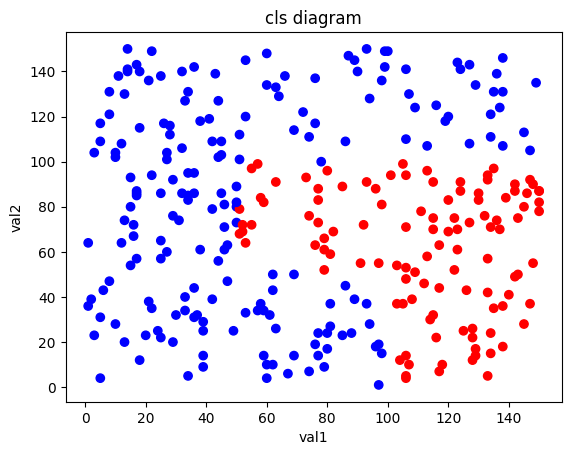

In [28]:
import matplotlib.pyplot as plt
colors = df.cls.map({1: "blue", 0: "red"}).fillna("gray")
plt.scatter(df.val1, df.val2, c=colors)
plt.xlabel("val1")
plt.ylabel("val2")
plt.title("cls diagram")